# ML Zoomcamp 2023 – Second Capstone Project

This notebook uses the [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs). First run the `make_dataset.py` file to download and extract the raw images.

In [1]:
import os
import re
import subprocess
from pathlib import Path
from time import time
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
try:
    import skimage
    print('Module skimage is installed.')
except ImportError:
    print('Module skimage is not installed, installing it now with pip.')
    p1 = subprocess.run('python -m pip install scikit-image -q', shell=True,
                        check=True, capture_output=True, text=True)
    if p1.stderr:
          print(p1.stderr)
    else:
        print('Installed scikit-image with pip.')
from skimage.io import imread
from skimage.transform import resize

Module skimage is installed.


In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img

In [5]:
images_dir = Path.cwd() / 'data/raw/Images'
annotation_dir = Path.cwd() / 'data/raw/Annotation'
processed_dir = Path.cwd() / 'data/processed'

## Data preparation

In [6]:
# folder names come from namimg in raw/Images and raw/Annotation folders
breed_dir_list = ['n02085936-Maltese_dog', 'n02088094-Afghan_hound', 'n02092002-Scottish_deerhound',
                  'n02112018-Pomeranian', 'n02107683-Bernese_mountain_dog', 'n02111889-Samoyed',
                  'n02090721-Irish_wolfhound', 'n02086240-Shih-Tzu', 'n02111500-Great_Pyrenees',
                  'n02111129-Leonberg']
breed_dir_list_30 = ['n02085936-Maltese_dog', 'n02088094-Afghan_hound', 'n02092002-Scottish_deerhound',
                     'n02112018-Pomeranian', 'n02107683-Bernese_mountain_dog', 'n02111889-Samoyed',
                     'n02090721-Irish_wolfhound', 'n02086240-Shih-Tzu', 'n02111500-Great_Pyrenees',
                     'n02111129-Leonberg', 'n02110806-basenji', 'n02097474-Tibetan_terrier',
                     'n02108000-EntleBucher', 'n02095889-Sealyham_terrier', 'n02096051-Airedale',
                     'n02110958-pug', 'n02091831-Saluki', 'n02095570-Lakeland_terrier', 'n02096177-cairn',
                     'n02086910-papillon', 'n02112137-chow', 'n02091467-Norwegian_elkhound',
                     'n02096294-Australian_terrier', 'n02088364-beagle', 'n02111277-Newfoundland',
                     'n02110185-Siberian_husky', 'n02086646-Blenheim_spaniel', 'n02099601-golden_retriever',
                     'n02099712-Labrador_retriever', 'n02085620-Chihuahua']

In [9]:
# modified from https://www.kaggle.com/code/hengzheng/dog-breeds-classifier/notebook
if not processed_dir.exists():
    Path.mkdir(processed_dir, exist_ok=True)
    for breed_dir in breed_dir_list_30:
        breed_name = re.sub(r'(n[0-9]+)-(\w+\-?\_?)', r'\2', breed_dir)
        breed_name = re.sub(r'-', r'_', breed_name.lower())
        Path.mkdir(processed_dir / breed_name, exist_ok=True)
    print(f'''Created {len(os.listdir(processed_dir))} folders to store cropped images of the different breeds.''')
else:
    print(f'Folder {processed_dir} already exists.')

Created 30 folders to store cropped images of the different breeds.


In [10]:
t0 = time()
img_size = 299
print(f'Saving {img_size}x{img_size} image sizes.')
if not list(processed_dir.glob('**/*.jpg')):
    for breed_dir in breed_dir_list_30:
        counter = 0
        for breed_prefix in os.listdir(f'{annotation_dir}/{breed_dir}'):
            img = Image.open(f'{images_dir}/{breed_dir}/{breed_prefix}.jpg')
            tree = ET.parse(f'{annotation_dir}/{breed_dir}/{breed_prefix}')
            xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
            xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
            ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
            ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
            img = img.crop((xmin, ymin, xmax, ymax))
            img = img.convert('RGB')
            img = img.resize((img_size, img_size))
            breed_name = re.sub(r'(n[0-9]+)-(\w+\-?\_?)', r'\2', breed_dir)
            breed_name = re.sub(r'-', r'_', breed_name.lower())
            img.save(str(processed_dir) + '/' + breed_name + '/' + breed_prefix + '.jpg')
            counter += 1
        print(f'Saved {counter} images in {breed_name} folder.')
    print(f'Time elapsed: {round(time()-t0, 0)} seconds.')
else:
    print(f'Folder {str(processed_dir)} with cropped images already exists.')

Saving 299x299 image sizes.
Saved 252 images in maltese_dog folder.
Saved 239 images in afghan_hound folder.
Saved 232 images in scottish_deerhound folder.
Saved 219 images in pomeranian folder.
Saved 218 images in bernese_mountain_dog folder.
Saved 218 images in samoyed folder.
Saved 218 images in irish_wolfhound folder.
Saved 214 images in shih_tzu folder.
Saved 213 images in great_pyrenees folder.
Saved 210 images in leonberg folder.
Saved 209 images in basenji folder.
Saved 206 images in tibetan_terrier folder.
Saved 202 images in entlebucher folder.
Saved 202 images in sealyham_terrier folder.
Saved 202 images in airedale folder.
Saved 200 images in pug folder.
Saved 200 images in saluki folder.
Saved 197 images in lakeland_terrier folder.
Saved 197 images in cairn folder.
Saved 196 images in papillon folder.
Saved 196 images in chow folder.
Saved 196 images in norwegian_elkhound folder.
Saved 196 images in australian_terrier folder.
Saved 195 images in beagle folder.
Saved 195 im

### Removal of corrupted images

In [11]:
num_skipped = 0
for folder_name in breed_dir_list_30:
    folder_name = re.sub(r'(n[0-9]+)-(\w+\-?\_?)', r'\2', str(folder_name))
    folder_name = re.sub(r'-', r'_', folder_name.lower())
    breed_dir = processed_dir / folder_name
    print(f'Looking into folder {str(breed_dir)}')
    for fname in os.listdir(breed_dir):
        fpath = breed_dir / fname
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print(f"Deleted {num_skipped} images.")

Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/maltese_dog
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/afghan_hound
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/scottish_deerhound
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/pomeranian
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/bernese_mountain_dog
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/samoyed
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/irish_wolfhound
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/shih_tzu
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/great_pyrenees
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/leonberg
Looking

## Pre-trained convolutional neural networks

In [12]:
model = Xception(weights='imagenet', input_shape=(img_size, img_size, 3))

In [13]:
path_to_image = 'data/processed/scottish_deerhound/n02092002_109.jpg'
img = load_img(path_to_image, target_size=(img_size, img_size))
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)
pred = model.predict(X)
decode_predictions(pred)

1/1 [==============================] - 2s 2s/step


[[('n02092002', 'Scottish_deerhound', 0.7939886),
  ('n02090721', 'Irish_wolfhound', 0.04308381),
  ('n02090622', 'borzoi', 0.005164035),
  ('n02091244', 'Ibizan_hound', 0.003001548),
  ('n02100236', 'German_short-haired_pointer', 0.0029592125)]]

## Data generation

In [14]:
new_img_size = 150
image_size_tuple = (new_img_size, new_img_size)
batch_size = 32

In [15]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    processed_dir,
    validation_split = 0.3,
    subset = 'both',
    seed = 33,
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = image_size_tuple,
    batch_size = batch_size,
    shuffle=True,
)

Found 6075 files belonging to 30 classes.
Using 4253 files for training.
Using 1822 files for validation.


In [16]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((1*val_batches) // 2)
val_ds = val_ds.skip((1*val_batches) // 2)

### Data visualization

In [17]:
names = train_ds.class_names

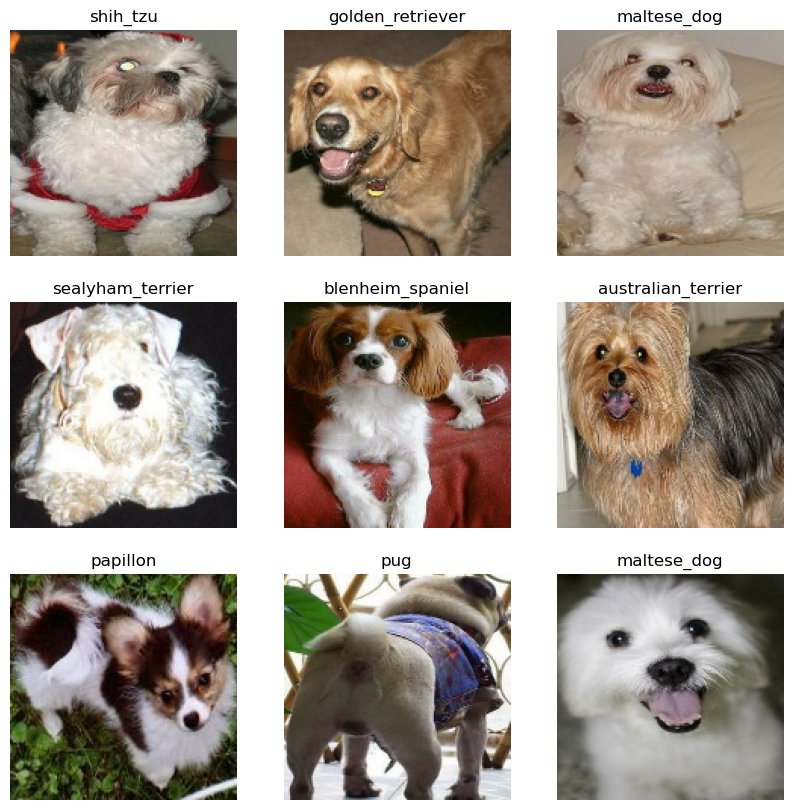

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype('uint8'))
        plt.title(names[list(labels[i]).index(1)])
        plt.axis('off')

## Transfer learning

Using a small image size to decrease training time.

In [22]:
num_layers = 30 # number of layers must be equal to the number of groups of images
base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
base_model.trainable = False
inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
base = base_model(inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(num_layers)(vectors)
model = keras.Model(inputs, outputs)

In [23]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [24]:
history = model.fit(train_ds, epochs = 10, validation_data = val_ds)

Epoch 1/10
  1/133 [..............................] - ETA: 8:33 - loss: 28.2662 - accuracy: 0.0000e+00

I0000 00:00:1709219051.976581    1752 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


133/133 [==============================] - 16s 90ms/step - loss: 48.0724 - accuracy: 0.1013 - val_loss: 32.0413 - val_accuracy: 0.1166
Epoch 2/10
133/133 [==============================] - 9s 64ms/step - loss: 30.0025 - accuracy: 0.1665 - val_loss: 40.1826 - val_accuracy: 0.1501
Epoch 3/10
133/133 [==============================] - 9s 64ms/step - loss: 29.2687 - accuracy: 0.1949 - val_loss: 43.5679 - val_accuracy: 0.1231
Epoch 4/10
133/133 [==============================] - 9s 65ms/step - loss: 25.5902 - accuracy: 0.2478 - val_loss: 36.8425 - val_accuracy: 0.1447
Epoch 5/10
133/133 [==============================] - 9s 65ms/step - loss: 21.6081 - accuracy: 0.2946 - val_loss: 38.0022 - val_accuracy: 0.1307
Epoch 6/10
133/133 [==============================] - 9s 65ms/step - loss: 20.7252 - accuracy: 0.3118 - val_loss: 38.9840 - val_accuracy: 0.1393
Epoch 7/10
133/133 [==============================] - 9s 65ms/step - loss: 21.2085 - accuracy: 0.3252 - val_loss: 36.4827 - val_accuracy: 0.

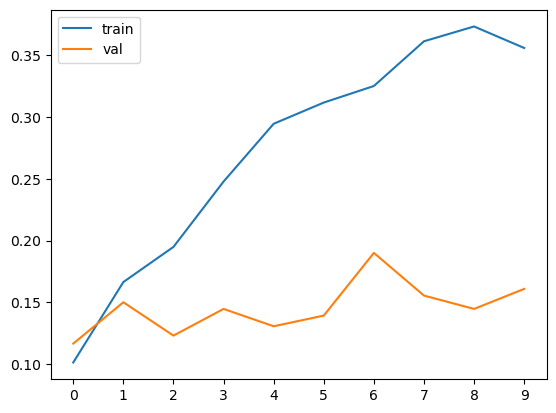

In [25]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

## Data augmentation

In [26]:
data_augmentation_layers = [
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
]

In [27]:
def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

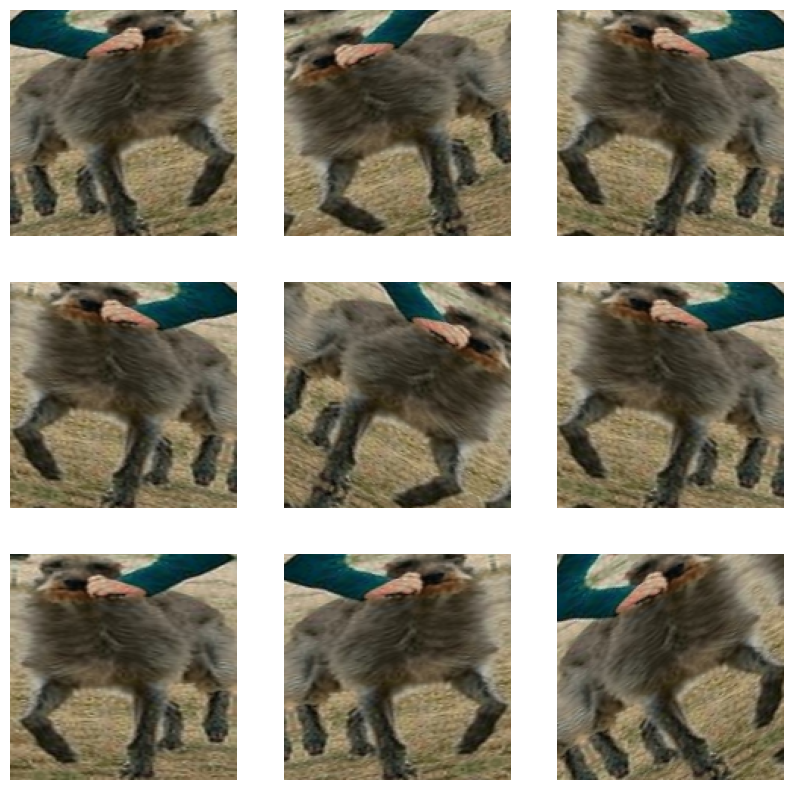

In [28]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [29]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
base_model.trainable = False
inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
augmented_inputs = data_augmentation(inputs)
scaled_inputs = keras.layers.Rescaling(1./255)(augmented_inputs)
base = base_model(scaled_inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(num_layers)(vectors)
model = keras.Model(inputs, outputs)

In [30]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [31]:
history = model.fit(train_ds, epochs = 10, validation_data = val_ds)

Epoch 1/10
133/133 [==============================] - 12s 73ms/step - loss: 1.5007 - accuracy: 0.7766 - val_loss: 1.1475 - val_accuracy: 0.8639
Epoch 2/10
133/133 [==============================] - 9s 67ms/step - loss: 1.1974 - accuracy: 0.8396 - val_loss: 1.0731 - val_accuracy: 0.8769
Epoch 3/10
133/133 [==============================] - 9s 68ms/step - loss: 1.1250 - accuracy: 0.8495 - val_loss: 1.1730 - val_accuracy: 0.8704
Epoch 4/10
133/133 [==============================] - 9s 67ms/step - loss: 0.9754 - accuracy: 0.8770 - val_loss: 1.0486 - val_accuracy: 0.8855
Epoch 5/10
133/133 [==============================] - 9s 68ms/step - loss: 0.9318 - accuracy: 0.8878 - val_loss: 1.1123 - val_accuracy: 0.8985
Epoch 6/10
133/133 [==============================] - 9s 68ms/step - loss: 0.9092 - accuracy: 0.8885 - val_loss: 1.3136 - val_accuracy: 0.8909
Epoch 7/10
133/133 [==============================] - 9s 68ms/step - loss: 0.7883 - accuracy: 0.9001 - val_loss: 1.0383 - val_accuracy: 0.900

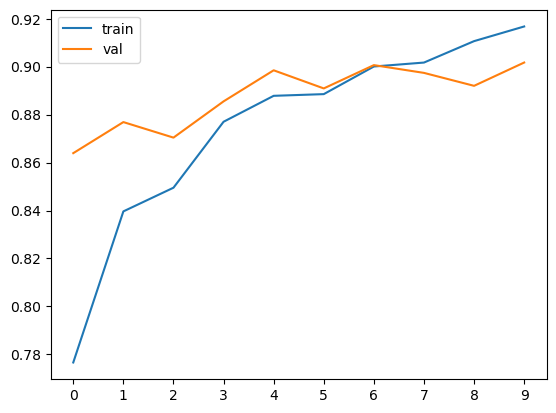

In [32]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

## Tuning the learning rate

In [33]:
def make_model(learning_rate=0.01, num_layers=30):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
    base_model.trainable = False
    inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
    augmented_inputs = data_augmentation(inputs)
    scaled_inputs = keras.layers.Rescaling(1./255)(augmented_inputs)
    base = base_model(scaled_inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(num_layers)(vectors)
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])    
    return model

In [34]:
learning_rate_scores = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(f'Learning rate: {lr}')
    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    learning_rate_scores[lr] = history.history
    print()
    print('*****'*10)
    print()

Learning rate: 0.0001
Epoch 1/10
133/133 [==============================] - 12s 72ms/step - loss: 2.4284 - accuracy: 0.4237 - val_loss: 1.2119 - val_accuracy: 0.8326
Epoch 2/10
133/133 [==============================] - 9s 67ms/step - loss: 1.0108 - accuracy: 0.8030 - val_loss: 0.5754 - val_accuracy: 0.9071
Epoch 3/10
133/133 [==============================] - 9s 67ms/step - loss: 0.6729 - accuracy: 0.8519 - val_loss: 0.4118 - val_accuracy: 0.9136
Epoch 4/10
133/133 [==============================] - 9s 68ms/step - loss: 0.5540 - accuracy: 0.8603 - val_loss: 0.3436 - val_accuracy: 0.9201
Epoch 5/10
133/133 [==============================] - 9s 67ms/step - loss: 0.4735 - accuracy: 0.8740 - val_loss: 0.3048 - val_accuracy: 0.9244
Epoch 6/10
133/133 [==============================] - 9s 68ms/step - loss: 0.4322 - accuracy: 0.8815 - val_loss: 0.2831 - val_accuracy: 0.9287
Epoch 7/10
133/133 [==============================] - 9s 68ms/step - loss: 0.4110 - accuracy: 0.8796 - val_loss: 0.2702

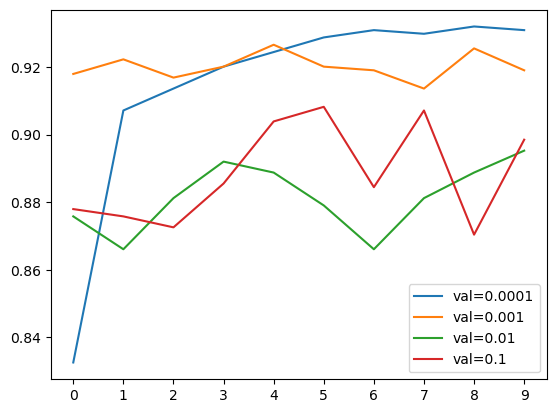

In [35]:
for lr, hist in learning_rate_scores.items():
    # plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))
plt.xticks(np.arange(10))
plt.legend()

## Adjusting inner layers

In [37]:
def make_model(learning_rate=0.01, size_inner=100, num_layers=30):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
    base_model.trainable = False
    inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
    augmented_inputs = data_augmentation(inputs)
    scaled_inputs = keras.layers.Rescaling(1./255)(augmented_inputs)
    base = base_model(scaled_inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    outputs = keras.layers.Dense(num_layers)(inner)
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])    
    return model

In [38]:
best_learning_rate = 0.0001
size_scores = {}
for size in [10, 100, 1000]:
    print(f'Inner layer size: {size}')
    model = make_model(learning_rate=best_learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    size_scores[size] = history.history
    print()
    print('*****'*10)
    print()

Inner layer size: 10
Epoch 1/10
133/133 [==============================] - 13s 75ms/step - loss: 3.1489 - accuracy: 0.1258 - val_loss: 2.7684 - val_accuracy: 0.3132
Epoch 2/10
133/133 [==============================] - 9s 69ms/step - loss: 2.5382 - accuracy: 0.3640 - val_loss: 2.1985 - val_accuracy: 0.4773
Epoch 3/10
133/133 [==============================] - 9s 70ms/step - loss: 2.1322 - accuracy: 0.4775 - val_loss: 1.8193 - val_accuracy: 0.5680
Epoch 4/10
133/133 [==============================] - 9s 70ms/step - loss: 1.8239 - accuracy: 0.5577 - val_loss: 1.5279 - val_accuracy: 0.6469
Epoch 5/10
133/133 [==============================] - 9s 70ms/step - loss: 1.5825 - accuracy: 0.6252 - val_loss: 1.2891 - val_accuracy: 0.7300
Epoch 6/10
133/133 [==============================] - 9s 70ms/step - loss: 1.3709 - accuracy: 0.7009 - val_loss: 1.0892 - val_accuracy: 0.7840
Epoch 7/10
133/133 [==============================] - 9s 70ms/step - loss: 1.1943 - accuracy: 0.7531 - val_loss: 0.9277 

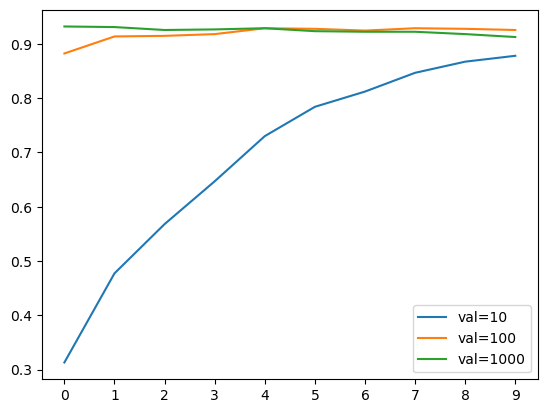

In [45]:
for size, hist in size_scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))
plt.xticks(np.arange(10))
# plt.ylim(0.90, 0.95)
plt.legend()

## Adding dropout

In [46]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5, num_layers=30):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
    base_model.trainable = False
    inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
    augmented_inputs = data_augmentation(inputs)
    scaled_inputs = keras.layers.Rescaling(1./255)(augmented_inputs)
    base = base_model(scaled_inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    outputs = keras.layers.Dense(num_layers)(drop)
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])    
    return model

In [47]:
best_learning_rate = 0.0001
best_size = 1000
droprate_scores = {}
for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(f'Dropout rate: {droprate}')
    model = make_model(learning_rate=best_learning_rate, size_inner=best_size, droprate=droprate)
    history = model.fit(train_ds, epochs=30, validation_data=val_ds)
    droprate_scores[droprate] = history.history
    print()
    print('*****'*10)
    print()

Dropout rate: 0.0
Epoch 1/30
133/133 [==============================] - 12s 73ms/step - loss: 0.9796 - accuracy: 0.7635 - val_loss: 0.2870 - val_accuracy: 0.9168
Epoch 2/30
133/133 [==============================] - 9s 69ms/step - loss: 0.4059 - accuracy: 0.8777 - val_loss: 0.2504 - val_accuracy: 0.9201
Epoch 3/30
133/133 [==============================] - 9s 68ms/step - loss: 0.3561 - accuracy: 0.8869 - val_loss: 0.2510 - val_accuracy: 0.9147
Epoch 4/30
133/133 [==============================] - 9s 68ms/step - loss: 0.3256 - accuracy: 0.9012 - val_loss: 0.2513 - val_accuracy: 0.9168
Epoch 5/30
133/133 [==============================] - 9s 68ms/step - loss: 0.2943 - accuracy: 0.9059 - val_loss: 0.2518 - val_accuracy: 0.9222
Epoch 6/30
133/133 [==============================] - 9s 68ms/step - loss: 0.2684 - accuracy: 0.9137 - val_loss: 0.2549 - val_accuracy: 0.9233
Epoch 7/30
133/133 [==============================] - 9s 68ms/step - loss: 0.2469 - accuracy: 0.9273 - val_loss: 0.2444 - v

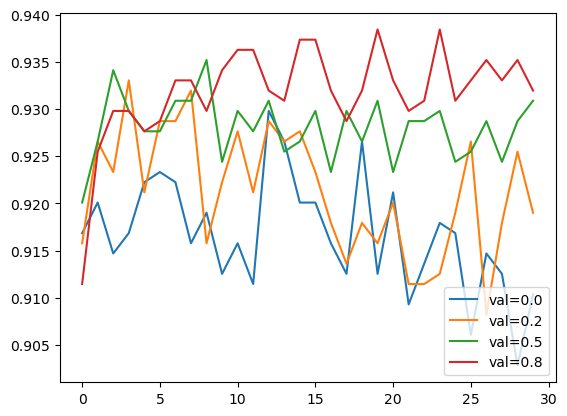

In [48]:
for droprate, hist in droprate_scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))
# plt.ylim(0.86, 0.95)
plt.legend(loc=4)

## Saving best model with checkpointing

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [ ]:
learning_rate = 0.0001
size = 1000
droprate = 0.8
model = make_model(learning_rate=learning_rate, size_inner=size, droprate=droprate)

In [ ]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[checkpoint])

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.linspace(0, 50, 11))
plt.legend()

## Testing the model

In [ ]:
best_model = keras.models.load_model('xception_v1_48_0.968.h5')

In [ ]:
loss, test_acc = best_model.evaluate(test_ds)
print(f'Test accuracy: {test_acc:.4f}')

In [ ]:
path_to_image = '/home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/test/samoyed.jpg'
img = keras.utils.load_img(path_to_image, target_size=image_size_tuple)
plt.imshow(img)

In [ ]:
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

In [ ]:
predictions = best_model.predict(img_array)

In [ ]:
dict(zip(names, predictions[0]))